In [1]:
import sys
sys.path.append('./codes/forgraph/')
from config import args
import matplotlib.pyplot as plt
from utils import get_graph_data
from models import GCN
from metrics import *
import numpy as np
from Explainer import Explainer
from scipy.sparse import coo_matrix
import networkx as nx
from sklearn.metrics import roc_auc_score
import pickle as pkl


In [2]:
clip_value_min = -2.0
clip_value_max = 2.0

args.dataset = "Mutagenicity"
args.coff_t0 = 5.0 # For this dataset, high temperature works well.
args.coff_te = 5.0
args.elr = 0.0003
args.coff_size = 0.005
args.coff_ent = 1.0

In [3]:
edge_lists, graph_labels, edge_label_lists, node_label_lists = get_graph_data(args.dataset)
with open('./dataset/Mutagenicity.pkl','rb') as fin:
    original_adjs,original_features,original_labels = pkl.load(fin)

# we only consider the mutagen graphs with NO2 and NH2.
selected =  []
for gid in range(original_adjs.shape[0]):
    if np.argmax(original_labels[gid]) == 0 and np.sum(edge_label_lists[gid]) > 0:
        selected.append(gid)
print('number of mutagen graphs with NO2 and NH2',len(selected))
selected_adjs = original_adjs[selected]
selected_features = original_features[selected]
selected_labels = original_labels[selected]
selected_edge_lists = [edge_lists[i] for i in selected]
selected_graph_labels=graph_labels[selected]
selected_edge_label_lists=[edge_label_lists[i] for i in selected]
selected_node_label_lists=[node_label_lists[i] for i in selected]


number of mutagen graphs with NO2 and NH2 1015


In [4]:
model = GCN(input_dim=selected_features.shape[-1], output_dim=selected_labels.shape[1])
model.load_weights(args.save_path+args.dataset)

selected_adjs_tensor = tf.convert_to_tensor(selected_adjs,dtype=tf.float32)
selected_features_tensor = tf.convert_to_tensor(selected_features,dtype=tf.float32)
selected_labels_tensor = tf.convert_to_tensor(selected_labels,dtype=tf.float32)
selected_output = model.call((selected_features_tensor,selected_adjs_tensor),training=False)
selected_acc = accuracy(selected_output, selected_labels_tensor)
selected_pred_label = tf.argmax(selected_output, 1)
selected_embs = model.getNodeEmb((selected_features_tensor, selected_adjs_tensor), training=False)


explainer = Explainer(model=model,nodesize=selected_adjs.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=args.elr)


In [5]:
reals = []
preds = []
def acc(explainer, gid):
    mask = explainer.masked_adj.numpy()
    edge_labels = selected_edge_label_lists[gid]
    edge_list = selected_edge_lists[gid]
    for (r,c),l in list(zip(edge_list,edge_labels)):
        if r>c:
            reals.append(l)
            preds.append(mask[r][c])


def explain_graph(fea,emb,adj,label,graphid, needplot=True):
    explainer((fea,emb,adj,1.0,label))
    acc(explainer,graphid)
    if not needplot:
        return
    after_adj_dense = explainer.masked_adj.numpy()
    after_adj = coo_matrix(after_adj_dense)
    rcd = np.concatenate(
        [np.expand_dims(after_adj.row, -1), np.expand_dims(after_adj.col, -1), np.expand_dims(after_adj.data, -1)], -1)
    pos_edges = []
    filter_edges = []
    edge_weights = np.triu(after_adj_dense).flatten()

    sorted_edge_weights = np.sort(edge_weights)
    thres_index = max(int(edge_weights.shape[0] - topk), 0)
    thres = sorted_edge_weights[thres_index]

    for r, c, d in rcd:
        r = int(r)
        c = int(c)
        d = float(d)
        if r < c:
            continue
        if d >= thres:
            pos_edges.append((r, c))
        filter_edges.append((r, c))

    node_label = selected_node_label_lists[graphid]
    max_label = np.max(node_label) + 1
    nmb_nodes = len(node_label)


    G = nx.Graph()
    G.add_nodes_from(range(nmb_nodes))
    G.add_edges_from(filter_edges)

    pos_edges = [(u, v) for (u, v) in pos_edges if u in G.nodes() and v in G.nodes()]
    pos = nx.kamada_kawai_layout(G)


    colors = ['orange','red','lime','green','blue','orchid','darksalmon','darkslategray','gold','bisque','tan','lightseagreen','indigo','navy']

    label2nodes = []
    for i in range(max_label):
        label2nodes.append([])
    for i in range(nmb_nodes):
        if i in G.nodes():
            label2nodes[node_label[i]].append(i)

    for i in range(max_label):
        node_filter = []
        for j in range(len(label2nodes[i])):
            node_filter.append(label2nodes[i][j])
        nx.draw_networkx_nodes(G, pos,
                               nodelist=node_filter,
                               node_color=colors[i],
                               node_size=300)

    nx.draw_networkx_edges(G, pos, width=2,  edge_color='grey')

    nx.draw_networkx_edges(G, pos,
                           edgelist=pos_edges,
                           width=7)

    plt.title('Graph: '+str(graphid)+' label: '+str(selected_graph_labels[graphid]))
    plt.axis('off')
    plt.show()
    plt.clf()


In [6]:
# for this dataset, small batch when explanining works better. Here we simply set batch size = 1 
def train():
    epochs = args.eepochs
    t0 = args.coff_t0
    t1 = args.coff_te

    for epoch in range(epochs):
        loss = 0
        tmp = t0 * np.power(t1 / t0, epoch /epochs )
        for gid in range(selected_adjs.shape[0]):
            with tf.GradientTape() as tape:
                    pred = explainer((selected_features[gid],selected_embs[gid],\
                                      selected_adjs[gid],tmp, selected_labels[gid]),training=True)
                    cl = explainer.loss(pred, selected_pred_label[gid])
                    loss += cl
            train_variables = [para for para in explainer.trainable_variables
                           if para.name.startswith('explainer')]
            grads = tape.gradient(cl, train_variables)
            cliped_grads = [tf.clip_by_value(t, clip_value_min, clip_value_max) for t in grads]
            optimizer.apply_gradients(zip(cliped_grads, train_variables))
        if epoch%1==0:
            print('epoch',epoch,'loss',loss.numpy())
            global  reals
            global preds
            reals =[]
            preds =[]
            for gid in range(int(selected_adjs.shape[0]/10)):
                fea, emb, adj, label = selected_features[gid], selected_embs[gid], selected_adjs[gid], selected_labels[
                    gid]
                explain_graph(fea, emb, adj, label, gid, needplot=False)

            auc = roc_auc_score(reals, preds)
            print(auc)

#     explainer.save_weights(args.save_path +args.dataset+ 'expaliner')



In [7]:
train()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 0 loss 530506.6
0.7588752187530613
epoch 1 loss 469832.9
0.6797746413244059
epoch 2 loss 450852.4
0.6915535504846324
epoch 3 loss 447866.56
0.7608052760193695
epoch 4 loss 446837.62
0.821553100402691
epoch 5 loss 446379.94
0.8606043276702435
epoch 6 loss 446160.28
0.8963699567656582
epoch 7 loss 446031.4
0.921598373350913
epoch 8 loss 445953.5
0.9362763397218494
epoch 9 loss 445875.6
0.9459848719516877
epoch 10 loss 445802.94
0.9492466422563401
epoch 11 loss 445751.7
0.9534694698828994
epoch 12 lo

In [8]:
reals = []
preds = []

for gid in range(selected_adjs.shape[0]):
    fea, emb, adj, label = selected_features[gid], selected_embs[gid], selected_adjs[gid], selected_labels[gid]
    explain_graph(fea,emb,adj,label,gid,needplot=False)

auc = roc_auc_score(reals, preds)
print(auc)

0.9622073433551513


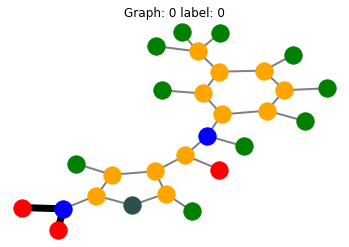

<Figure size 432x288 with 0 Axes>

In [9]:
gid = 0
topk = 2
fea, emb, adj, label = selected_features[gid], selected_embs[gid], selected_adjs[gid], selected_labels[gid]
explain_graph(fea,emb,adj,label,gid,needplot=True)

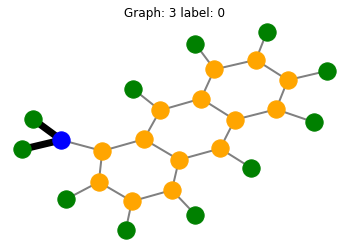

<Figure size 432x288 with 0 Axes>

In [14]:
gid = 3
topk = 2
fea, emb, adj, label = selected_features[gid], selected_embs[gid], selected_adjs[gid], selected_labels[gid]
explain_graph(fea,emb,adj,label,gid,needplot=True)

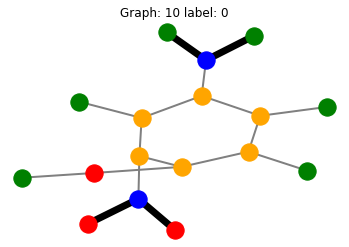

<Figure size 432x288 with 0 Axes>

In [11]:
gid = 10
topk = 4
fea, emb, adj, label = selected_features[gid], selected_embs[gid], selected_adjs[gid], selected_labels[gid]
explain_graph(fea,emb,adj,label,gid,needplot=True)